In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time

### a) Making the Green's Function

In [2]:
def greens(n):
    
    dx = np.arange(-n//2,n//2)
    kern = np.zeros([n,n])
    x,y = np.meshgrid(dx,dx)
    
    # Calculate r matrix
    dr = np.sqrt(x**2 + y**2)
    # Deal with origin to deal with singularity
    dr[n//2,n//2] = 1
    
    # Compute kernel
    kern = -np.log(dr)/2/np.pi
    
    # Set origin to desired value of 1
    kern[n//2,n//2] = 1
    
    return kern, x, y
    

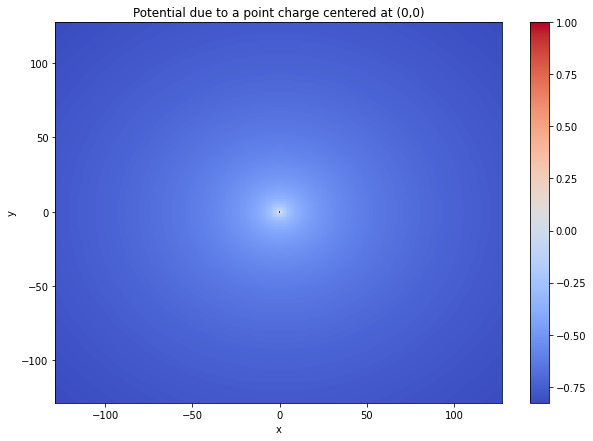

In [3]:
n = 256
kern, x, y = greens(n)
plt.figure(figsize=(10,7))
plt.pcolormesh(x,y,kern, shading = 'auto', cmap = 'coolwarm')
plt.title('Potential due to a point charge centered at (0,0)')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.savefig('greens_function.jpeg')
plt.show()

In [4]:
print('''The potential at (x,y) = (1,0) and (x,y) = (2,0) are:
V(1,0) = {0} 
V(2,0) = {1}
as expected, when plugging in r = 1 and r = 2 into -ln(r)/(2π). 
'''.format(np.abs(kern[n//2,n//2+1]), kern[n//2,n//2+2]))

The potential at (x,y) = (1,0) and (x,y) = (2,0) are:
V(1,0) = 0.0 
V(2,0) = -0.1103178000763258
as expected, when plugging in r = 1 and r = 2 into -ln(r)/(2π). 



### b) Getting Charge Density

In [5]:
# Copied and slightly modified Jon's code. Using conjugate gradient to solve for the charge density.
def rho2pot(rho,kernelft):
    tmp=rho.copy()
    tmp=np.pad(tmp,(0,tmp.shape[0]))

    tmpft=np.fft.rfftn(tmp)
    tmp=np.fft.irfftn(tmpft*kernelft)
    
    tmp=tmp[:rho.shape[0],:rho.shape[1]]
    return tmp

    
def rho2pot_masked(rho,mask,kernelft,return_mat=False):
    rhomat=np.zeros(mask.shape)
    rhomat[mask]=rho
    potmat=rho2pot(rhomat,kernelft)
    if return_mat:
        return potmat
    else:

        return potmat[mask]

def cg(rhs,x0,mask,kernelft,fun=rho2pot_masked):

    t1=time.time()
    Ax = fun(x0,mask,kernelft)
    r = rhs-Ax
    p = r.copy()
    x = x0.copy()
    rsqr = np.sum(r*r)
    print('Starting rsqr is ',rsqr)
    
    while rsqr > 1e-16:
        
        Ap = fun(p,mask,kernelft)
        alpha = np.sum(r*r)/np.sum(Ap*p)
        x = x + alpha*p
        r = r - alpha*Ap
        rsqr_new = np.sum(r*r)
        beta = rsqr_new / rsqr
        p = r + beta*p
        rsqr = rsqr_new
        
        # Check if rsqr is below machine precision. If yes, break. 
        if np.abs(rsqr) <= 1e-16:
            print('Achieved rsqr to machine precision. Stopping.')
            t2=time.time()
            print('Final rsqr is ',rsqr,' after ',t2-t1,' seconds')
            return x
    return x

# For this problem, the potential is held fixed at 1 on the boundaries
def get_bc(n):
    
    bc = np.zeros([n,n])
    mask = np.zeros([n,n], dtype = bool)
    
    # Set boundary to 1
    bc[0,:] = 1
    bc[-1,:] = 1
    bc[:,0] = 1
    bc[:,-1] = 1
    
    # Set mask
    mask[0,:] = True
    mask[-1,:] = True
    mask[:,0] = True
    mask[:,-1] = True
    
    return bc, mask

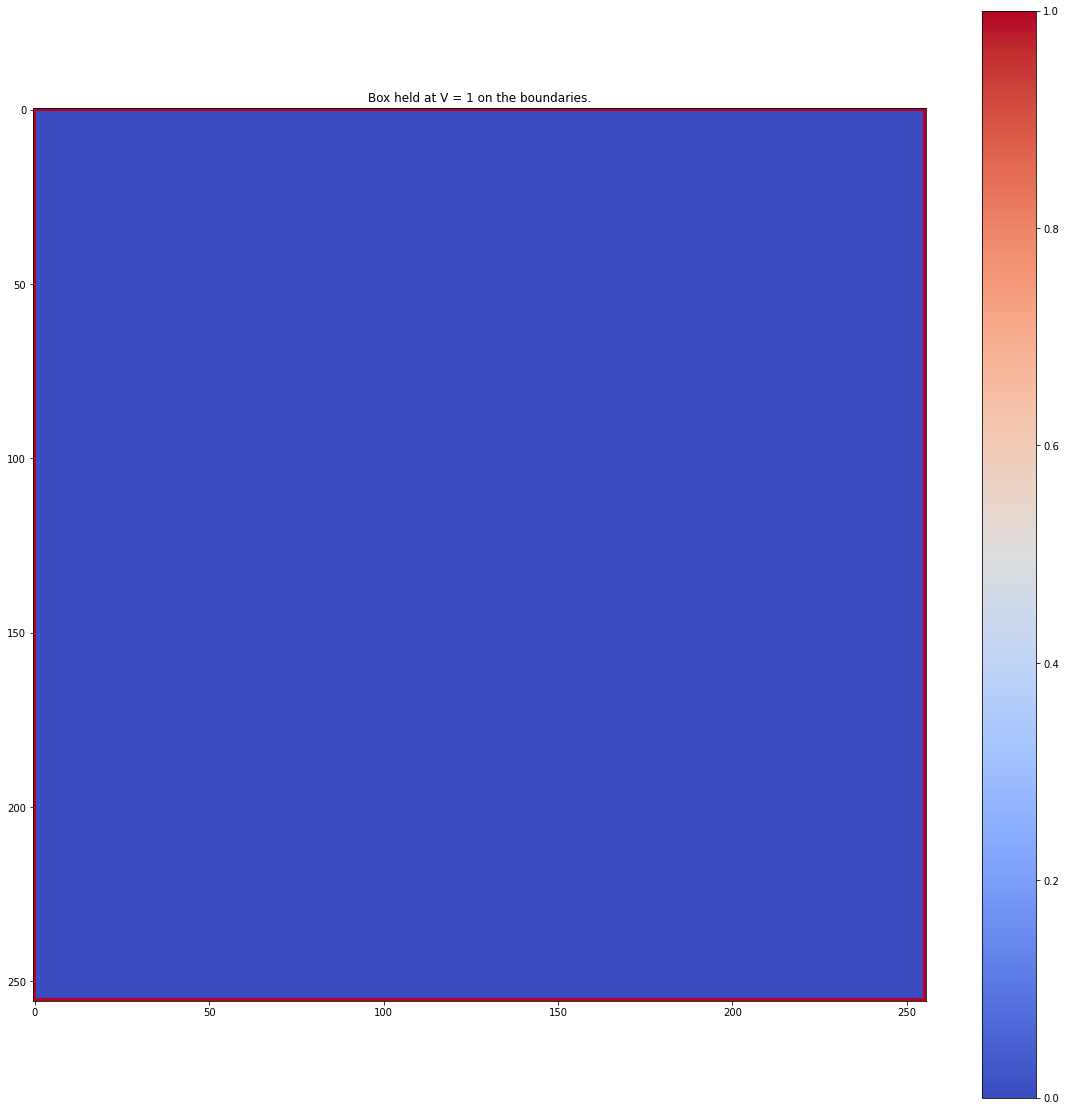

In [6]:
# Carry out conjugate gradient solver
n = 256
bc, mask = get_bc(n)

# Visualize box
plt.figure(figsize = (20,20))
plt.imshow(bc, cmap = 'coolwarm')
plt.title('Box held at V = 1 on the boundaries.')
plt.colorbar()
plt.show()

In [7]:
# Get our green's function
kern, x, y = greens(2*n)
kernelft = np.fft.rfft2(kern)

# Solving for the charge that gives us the potential, so rhs is the potential on the mask
rhs = bc[mask]
x0 = 0*rhs

# Solve for charge on boundary 
rho_out = cg(rhs, x0, mask, kernelft)


Starting rsqr is  1020.0
Achieved rsqr to machine precision. Stopping.
Final rsqr is  6.47513786097238e-17  after  14.031606674194336  seconds


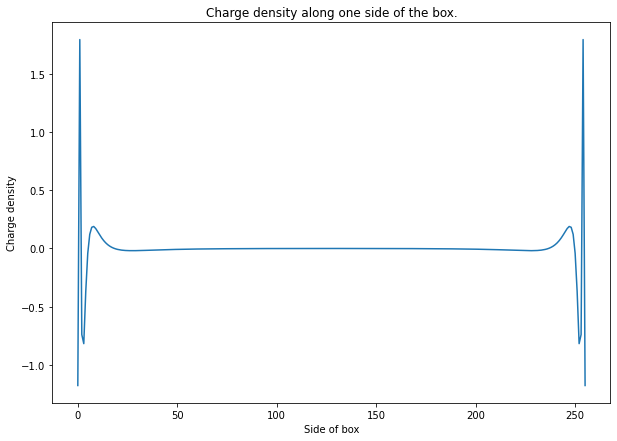

In [8]:
plt.figure(figsize=(10,7))
plt.plot(rho_out[:n])
plt.xlabel('Side of box')
plt.ylabel('Charge density')
plt.title('Charge density along one side of the box.')
plt.savefig('Charge_density_border.jpeg')
plt.show()

### c) Potential Everywhere in Space

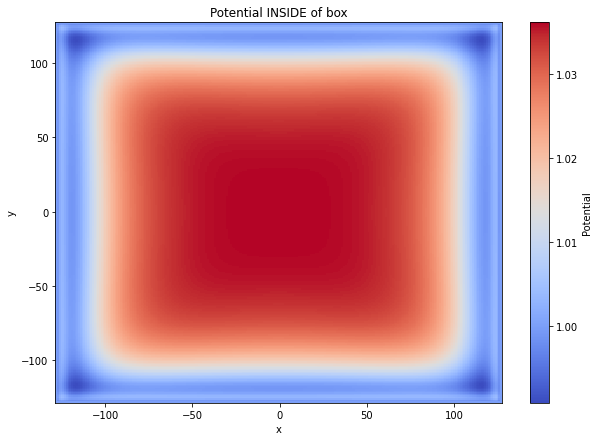

In [9]:
# Get x and y with same shape as potential matrix for plotting purposes
a,x_true,y_true = greens(n) 

# Get potential inside of box
pot_interior = rho2pot_masked(rho_out, mask, kernelft, True)

# Plot results
plt.figure(figsize=(10,7))
plt.pcolormesh(x_true,y_true,pot_interior,shading='auto', cmap = 'coolwarm')
plt.colorbar(label='Potential')
plt.title('Potential INSIDE of box')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('potential_inside_box.jpeg')
plt.show()

# Get average potential and std inside box
mean_pot = np.mean(pot_interior)
std_pot = np.std(pot_interior)

In [10]:
print('The potential is roughly constant within the box, with mean value {0} and standard deviation {1}.'.format(round(mean_pot,2), round(std_pot, 2)))

The potential is roughly constant within the box, with mean value 1.02 and standard deviation 0.01.


Now that we have the potential inside of the box, we can get the potential everywhere in space by simply increasing our mask to include points outside of the box. This requires also increasing our kernel size to compensate for an increase in mask size. 

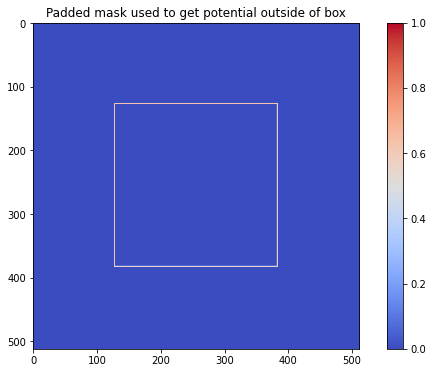

In [11]:
def pad_array(array):
    s = np.shape(array)
    new_array = np.zeros((s[0]*2,s[1]*2), dtype = bool)
    new_array[s[0]//2-1:3*s[0]//2-1,s[1]//2-1:3*s[1]//2-1] = array
    return new_array

# Pad our array with more false values to indicate an area outside of the box
mask_padded = pad_array(mask)
plt.figure(figsize=(10,6))
plt.imshow(mask_padded, cmap = 'coolwarm')
plt.colorbar()
plt.title('Padded mask used to get potential outside of box')
plt.show()


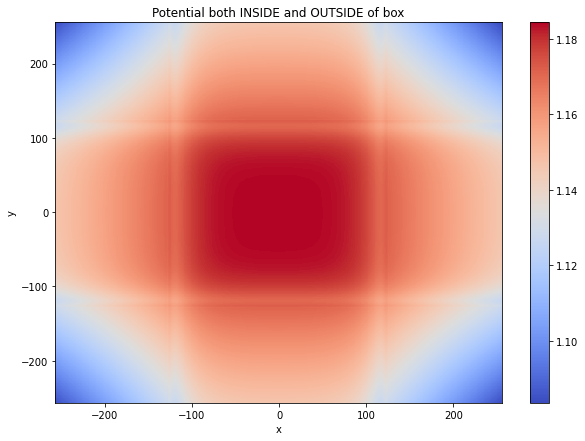

In [13]:
# Double kernel and fft of kernel
dbl_kern, x_large, y_large = greens(4*n)
dbl_kernft = np.fft.rfft2(dbl_kern)

# Compute new potential both inside and outside of box
pot_new = rho2pot_masked(rho_out, mask_padded, dbl_kernft, True)

# Plot
plt.figure(figsize=(10,7))
plt.pcolormesh(x, y, pot_new, shading = 'auto', cmap = 'coolwarm')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Potential both INSIDE and OUTSIDE of box')
plt.colorbar()
plt.savefig('potential_inside_outside_box.jpeg')
plt.show()

Clearly, the potential is perpendicular to the boundary of the box, and as we'd expect, the potential decreases the further we get away from the box and strongest in the center where the charge is located. 